# PyTorch Experiment Tracking

In order to figure out which experiments are worth pursuing, that's where **experiment tracking** comes in, it helps to figure out what doesn't work so we can figure out what **does** work.

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular import data_setup, engine
except:
  print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
  !git clone https://github.com/almosenja/PyTorch
  !mv PyTorch/going_modular .
  !rm -rf PyTorch/
  from going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'PyTorch'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 39 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 5.13 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
  """Sets random sets for torch operations.

  Args:
    seed (int, optional): Random seed to set. Defaults to 42.
  """
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

## 1. Get data

Building FoodVision Mini and see which model performs best.

In [5]:
import os
import zipfile
import requests

from pathlib import Path

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
  """Downloads a zipped dataset from source and unzips to destination."""
  # Setup path to data folder
  data_path = Path("data/")
  image_path = data_path / destination

  # If the image folder doesn't exist, create it
  if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists, skipping download.")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the target data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)

    # Unzip target file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    # Remove .zip file if needed
    if remove_source:
      os.remove(data_path / target_file)

  return image_path

In [6]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [7]:
image_path

PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

### 2.1. Create DataLoaders with manual transforms

The goal with transforms is to ensure the custom data is formatted in a reproducible way as well as a way that will suit pretrained models.

In [8]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [9]:
# Setup ImageNet normalization levels
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor(),
                                        normalize])

print(f"Manually created transforms: {manual_transforms}")

# Create DataLoaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7e88e6518970>,
 ['pizza', 'steak', 'sushi'])

### 2.2. Create DataLoaders using automatically created transforms

In [10]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms weights
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create DataLoader
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=automatic_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7e88e6519c60>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freeze the base layers and change the classifier head

In [11]:
import torchvision
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Use this function to prevent error when getting the weights
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights="DEFAULT").to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 81.3MB/s]


In [12]:
# Freeze all base layers by setting their requires_grad attribute to False
for param in model.features.parameters():
  param.requires_grad = False

In [13]:
print(f"Classifier layer before adjustment:\n{model.classifier}\n")

# Adjust the classifier head
set_seeds()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
)

print(f"Classifier layer after adjustment:\n{model.classifier}")

Classifier layer before adjustment:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Classifier layer after adjustment:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [14]:
from torchinfo import summary

summary(model,
        input_size=(32, 3, 256, 256),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 256, 256]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 32, 128, 128]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 256, 256]    [32, 32, 128, 128]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 128, 128]   [32, 32, 128, 128]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Sequential (1)                                        [32, 32, 128, 128]   [32, 

## 4. Train a single model and track results

In [15]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [16]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [17]:
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from going_modular.engine import train_step, test_step

import torch

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to minimize.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epoch=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2642, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # Print out
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {100*train_acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {100*test_acc:.2f}%")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    # Experiment tracking
    writer.add_scalars(main_tag="Loss",
                       tag_scalar_dict={"train_loss": train_loss,
                                        "test_loss": test_loss},
                       global_step=epoch)

    writer.add_scalars(main_tag="Accuracy",
                       tag_scalar_dict={"train_acc": train_acc,
                                        "test_acc": test_acc},
                       global_step=epoch)

    writer.add_graph(model=model,
                     input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()

  # Return the filled results at the end of the epochs
  return results

In [18]:
# Train model
# set_seeds()
# results = train(model=model,
#                 train_dataloader=train_dataloader,
#                 test_dataloader=test_dataloader,
#                 optimizer=optimizer,
#                 loss_fn=loss_fn,
#                 epochs=10,
#                 device=device)

## 5. Create a funciton to prepare a `SummaryWriter()` instance

By default `SummaryWriter()` class saves to `log_dir`

We'd like to track:
* Experiment data/timestep
* Experiment name
* Model name
* Extra - is there anything else that should be tracked?

Directory will be:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`


In [19]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
  """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""
  from datetime import datetime
  import os

  # Get timestamp of current date in reverse order
  timestamp = datetime.now().strftime("%Y-%m-%d")

  if extra:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

  print(f"[INFO] Created SummaryWriter saving to {log_dir}")

  return SummaryWriter(log_dir=log_dir)

### 5.1. Update the `train()` function to include a `writer` function

In [21]:
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from going_modular.engine import train_step, test_step

import torch

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter=None) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to minimize.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    writer: A function that creates a model tracking.

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epoch=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2642, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # Print out
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {100*train_acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {100*test_acc:.2f}%")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    # Experiment tracking
    if writer:
      writer.add_scalars(main_tag="Loss",
                        tag_scalar_dict={"train_loss": train_loss,
                                          "test_loss": test_loss},
                        global_step=epoch)

      writer.add_scalars(main_tag="Accuracy",
                        tag_scalar_dict={"train_acc": train_acc,
                                          "test_acc": test_acc},
                        global_step=epoch)

      writer.add_graph(model=model,
                       input_to_model=torch.randn(32, 3, 224, 224).to(device))

      # Close the writer
      writer.close()

  # Return the filled results at the end of the epochs
  return results

## 6. Setting up a series of modelling experiments

Things to test:
* Change the number of epochs
* Change the number of hidden layers/units
* Change the amount of data
* Change the learning rate
* Try different kinds of data augmentation
* Choos a different model architecture

We're going to turn three dials:
1. Model size - EfficientNetB0 vs EfficientNetB2
2. Dataset size - 10% of data vs 20%
3. Training time - 5 epochs vs 10 epochs

**Goal:** a model that is well performing but still small enough to run on a mobile device or web browser.

### 6.1. Download different datasets

Use two datasets:
1. Pizza, steak, sushi 10%
2. Pizza, steak, sushi 20%

In [22]:
# Download 10% and 20% datasets
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory already exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


### 6.2. Transform Datasets and Create DataLoaders

Transform in a few ways:
1. Resize the image to (224, 224)
2. Make sure image tensor values are between [0, 1]
3. Normalize the images so they have the same data distribution as ImageNet

In [23]:
# Setup train directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup test directory (should be the same)
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [24]:
# Setup ImageNet normalization levels
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Compose transforms into a pipeline
simple_transform = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize])

In [25]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% test data: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Number of batches of size 32 in 10% test data: 3
Class names: ['pizza', 'steak', 'sushi']


### 6.3. Create feature extractor models

Make two functions:
1. Creates a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head.
2. Creates a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head.

In [26]:
import torchvision
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
from torch import nn

OUT_FEATURES = len(class_names)

# Use this function to prevent error when getting the weights
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

# Create an EffNetB0 feature extractor
def create_effnetb0():
  WeightsEnum.get_state_dict = get_state_dict

  # Get the weights and setup a model
  model = torchvision.models.efficientnet_b0(weights="DEFAULT").to(device)

  # Freeze the base model layers
  for param in model.parameters():
    param.requires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1280, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb0"
  print(f"[INFO] Created new {model.name} model...")
  return model


# Create an EffNetB2 feature extractor
def create_effnetb2():
  WeightsEnum.get_state_dict = get_state_dict

  # Get the weights and setup a model
  model = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)

  # Freeze the base model layers
  for param in model.parameters():
    param.requires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1408, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb2"
  print(f"[INFO] Created new {model.name} model...")
  return model

In [27]:
effnetb0 = create_effnetb0()
effnetb2 = create_effnetb2()

[INFO] Created new effnetb0 model...


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 38.7MB/s]


[INFO] Created new effnetb2 model...


In [28]:
from torchinfo import summary

summary(effnetb0,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [29]:
summary(effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 6.4. Create experiments and set up training code

In [30]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# Create a DataLoaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [31]:
%%time
from going_modular.utils import save_model

# Set seeds
# set_seeds()

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
  # Loop through the epochs
  for epochs in num_epochs:
    # Loop through each model name and create a new model instance
    for model_name in models:
      # Print out info
      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] DataLoader: {dataloader_name}")
      print(f"[INFO] Number of epochs: {epochs}")

      # Select and create the model
      if model_name == "effnetb0":
        model = create_effnetb0()
      else:
        model = create_effnetb2()

      # Create a new loss and optimizer for every model
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

      # Train target model with target dataloader and track experiments
      train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(experiment_name=dataloader_name,
                                 model_name=model_name,
                                 extra=f"{epochs}_epochs"))

      # Save the model to file so we can import it later if need be
      save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epoch.pt"
      save_model(model=model,
                 target_dir="models",
                 model_name=save_filepath)
      print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2023-11-04/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.0434 | Train acc: 48.44% | Test loss: 0.9280 | Test acc: 47.82%
Epoch: 2 | Train loss: 0.9398 | Train acc: 53.91% | Test loss: 0.8326 | Test acc: 55.97%
Epoch: 3 | Train loss: 0.8216 | Train acc: 70.31% | Test loss: 0.7280 | Test acc: 82.48%
Epoch: 4 | Train loss: 0.7013 | Train acc: 77.73% | Test loss: 0.6176 | Test acc: 86.55%
Epoch: 5 | Train loss: 0.6141 | Train acc: 88.67% | Test loss: 0.5818 | Test acc: 88.64%
[INFO] Saving model to: models/effnetb0_data_10_percent_5_epoch.pt
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs/2023-11-04/data_10_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.0903 | Train acc: 39.06% | Test loss: 0.9549 | Test acc: 66.00%
Epoch: 2 | Train loss: 0.8865 | Train acc: 65.62% | Test loss: 0.8967 | Test acc: 69.22%
Epoch: 3 | Train loss: 0.8412 | Train acc: 65.62% | Test loss: 0.7889 | Test acc: 81.53%
Epoch: 4 | Train loss: 0.6971 | Train acc: 85.16% | Test loss: 0.6762 | Test acc: 89.68%
Epoch: 5 | Train loss: 0.7068 | Train acc: 73.05% | Test loss: 0.6357 | Test acc: 89.68%
[INFO] Saving model to: models/effnetb2_data_10_percent_5_epoch.pt
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2023-11-04/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.0434 | Train acc: 48.44% | Test loss: 0.9280 | Test acc: 47.82%
Epoch: 2 | Train loss: 0.9398 | Train acc: 53.91% | Test loss: 0.8326 | Test acc: 55.97%
Epoch: 3 | Train loss: 0.8216 | Train acc: 70.31% | Test loss: 0.7280 | Test acc: 82.48%
Epoch: 4 | Train loss: 0.7013 | Train acc: 77.73% | Test loss: 0.6176 | Test acc: 86.55%
Epoch: 5 | Train loss: 0.6141 | Train acc: 88.67% | Test loss: 0.5818 | Test acc: 88.64%
Epoch: 6 | Train loss: 0.5409 | Train acc: 87.50% | Test loss: 0.5932 | Test acc: 85.61%
Epoch: 7 | Train loss: 0.6397 | Train acc: 70.31% | Test loss: 0.5925 | Test acc: 85.61%
Epoch: 8 | Train loss: 0.5071 | Train acc: 80.08% | Test loss: 0.5386 | Test acc: 89.68%
Epoch: 9 | Train loss: 0.4676 | Train acc: 92.19% | Test loss: 0.5325 | Test acc: 87.59%
Epoch: 10 | Train loss: 0.5791 | Train acc: 73.44% | Test loss: 0.4894 | Test acc: 87.59%
[INFO] Saving model to: models/effnetb0_data_10_percent_10_epoch.pt
-----------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.0903 | Train acc: 39.06% | Test loss: 0.9549 | Test acc: 66.00%
Epoch: 2 | Train loss: 0.8865 | Train acc: 65.62% | Test loss: 0.8967 | Test acc: 69.22%
Epoch: 3 | Train loss: 0.8412 | Train acc: 65.62% | Test loss: 0.7889 | Test acc: 81.53%
Epoch: 4 | Train loss: 0.6971 | Train acc: 85.16% | Test loss: 0.6762 | Test acc: 89.68%
Epoch: 5 | Train loss: 0.7068 | Train acc: 73.05% | Test loss: 0.6357 | Test acc: 89.68%
Epoch: 6 | Train loss: 0.5829 | Train acc: 90.23% | Test loss: 0.6463 | Test acc: 87.69%
Epoch: 7 | Train loss: 0.6000 | Train acc: 81.25% | Test loss: 0.5898 | Test acc: 92.80%
Epoch: 8 | Train loss: 0.5325 | Train acc: 81.64% | Test loss: 0.5853 | Test acc: 88.73%
Epoch: 9 | Train loss: 0.4866 | Train acc: 81.64% | Test loss: 0.5450 | Test acc: 89.77%
Epoch: 10 | Train loss: 0.5146 | Train acc: 80.86% | Test loss: 0.5342 | Test acc: 93.84%
[INFO] Saving model to: models/effnetb2_data_10_percent_10_epoch.pt
-----------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.9633 | Train acc: 60.62% | Test loss: 0.6667 | Test acc: 88.64%
Epoch: 2 | Train loss: 0.6933 | Train acc: 78.12% | Test loss: 0.5816 | Test acc: 90.72%
Epoch: 3 | Train loss: 0.5806 | Train acc: 82.92% | Test loss: 0.5024 | Test acc: 91.76%
Epoch: 4 | Train loss: 0.4574 | Train acc: 88.75% | Test loss: 0.4179 | Test acc: 90.72%
Epoch: 5 | Train loss: 0.4503 | Train acc: 86.46% | Test loss: 0.3826 | Test acc: 92.80%
[INFO] Saving model to: models/effnetb0_data_20_percent_5_epoch.pt
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs/2023-11-04/data_20_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.9764 | Train acc: 53.12% | Test loss: 0.7729 | Test acc: 82.58%
Epoch: 2 | Train loss: 0.6987 | Train acc: 78.33% | Test loss: 0.6461 | Test acc: 85.61%
Epoch: 3 | Train loss: 0.5600 | Train acc: 89.17% | Test loss: 0.5425 | Test acc: 93.84%
Epoch: 4 | Train loss: 0.5076 | Train acc: 85.62% | Test loss: 0.5002 | Test acc: 91.76%
Epoch: 5 | Train loss: 0.4582 | Train acc: 86.46% | Test loss: 0.4362 | Test acc: 94.89%
[INFO] Saving model to: models/effnetb2_data_20_percent_5_epoch.pt
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2023-11-04/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.9633 | Train acc: 60.62% | Test loss: 0.6667 | Test acc: 88.64%
Epoch: 2 | Train loss: 0.6933 | Train acc: 78.12% | Test loss: 0.5816 | Test acc: 90.72%
Epoch: 3 | Train loss: 0.5806 | Train acc: 82.92% | Test loss: 0.5024 | Test acc: 91.76%
Epoch: 4 | Train loss: 0.4574 | Train acc: 88.75% | Test loss: 0.4179 | Test acc: 90.72%
Epoch: 5 | Train loss: 0.4503 | Train acc: 86.46% | Test loss: 0.3826 | Test acc: 92.80%
Epoch: 6 | Train loss: 0.4219 | Train acc: 89.38% | Test loss: 0.3726 | Test acc: 91.76%
Epoch: 7 | Train loss: 0.3983 | Train acc: 86.25% | Test loss: 0.3387 | Test acc: 91.76%
Epoch: 8 | Train loss: 0.3435 | Train acc: 89.58% | Test loss: 0.3489 | Test acc: 93.84%
Epoch: 9 | Train loss: 0.3729 | Train acc: 89.38% | Test loss: 0.3443 | Test acc: 92.80%
Epoch: 10 | Train loss: 0.3833 | Train acc: 89.38% | Test loss: 0.2842 | Test acc: 91.76%
[INFO] Saving model to: models/effnetb0_data_20_percent_10_epoch.pt
-----------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.9764 | Train acc: 53.12% | Test loss: 0.7729 | Test acc: 82.58%
Epoch: 2 | Train loss: 0.6987 | Train acc: 78.33% | Test loss: 0.6461 | Test acc: 85.61%
Epoch: 3 | Train loss: 0.5600 | Train acc: 89.17% | Test loss: 0.5425 | Test acc: 93.84%
Epoch: 4 | Train loss: 0.5076 | Train acc: 85.62% | Test loss: 0.5002 | Test acc: 91.76%
Epoch: 5 | Train loss: 0.4582 | Train acc: 86.46% | Test loss: 0.4362 | Test acc: 94.89%
Epoch: 6 | Train loss: 0.3686 | Train acc: 91.25% | Test loss: 0.4544 | Test acc: 89.77%
Epoch: 7 | Train loss: 0.3433 | Train acc: 93.54% | Test loss: 0.4079 | Test acc: 93.84%
Epoch: 8 | Train loss: 0.3214 | Train acc: 90.00% | Test loss: 0.4031 | Test acc: 91.76%
Epoch: 9 | Train loss: 0.3341 | Train acc: 89.79% | Test loss: 0.4290 | Test acc: 86.74%
Epoch: 10 | Train loss: 0.3655 | Train acc: 87.71% | Test loss: 0.3676 | Test acc: 94.89%
[INFO] Saving model to: models/effnetb2_data_20_percent_10_epoch.pt
-----------------------------------------

In [37]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir runs (started 0:11:16 ago; pid 4043)


In [41]:
%load_ext tensorboard
%tensorboard --runs --host=127.0.0.1 --port=6006 --load_fast=false

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-11-04 17:53:53.943264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 17:53:53.943349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 17:53:53.943387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-04 17:53:55.429515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--loa

In [42]:
# Access tensorboard via colab's proxy
# Click the link that appears in the output
from google.colab import output
output.serve_kernel_port_as_window(6006, path="")

<IPython.core.display.Javascript object>

## 9. Load in the best model and make predictions with it

In [44]:
# Setup best model filepath
best_model_path = "models/effnetb2_data_20_percent_10_epoch.pt"

# Instantiate a new instance of best model (to load in the saved state_dict())
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [46]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


In [47]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = "cpu"):

  # Open the image with PIL
  img = Image.open(image_path)

  # Create a transform if one doesn't exist:
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])])

  ### Predict on image
  # Make sure the model is on the target device
  model.to(device)

  # Turn on inference and eval mode
  model.eval()
  with torch.inference_mode():
    # Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0)
    # Make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

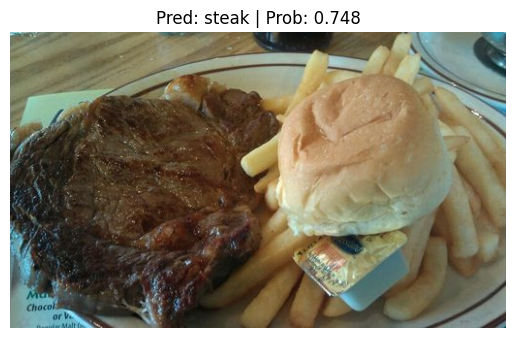

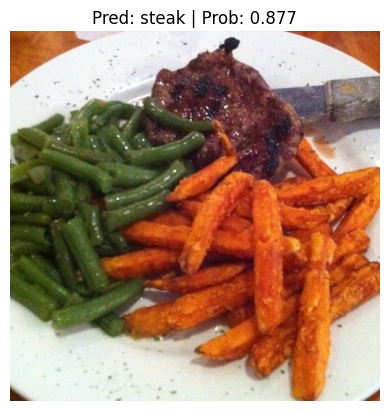

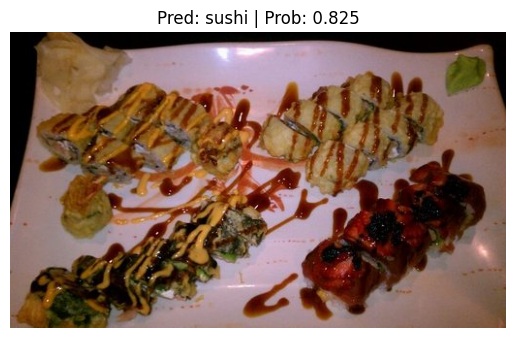

In [51]:
# Import function to make prediction on images and plot them
# from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=best_model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224),
                      device=device)